Multi-level Perturbed Unit Gradient Descent, MPUGD

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models  as models
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_10',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [38]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [39]:
print(device)

cuda


In [40]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


{'train': 50000, 'valid': 10000}


In [41]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


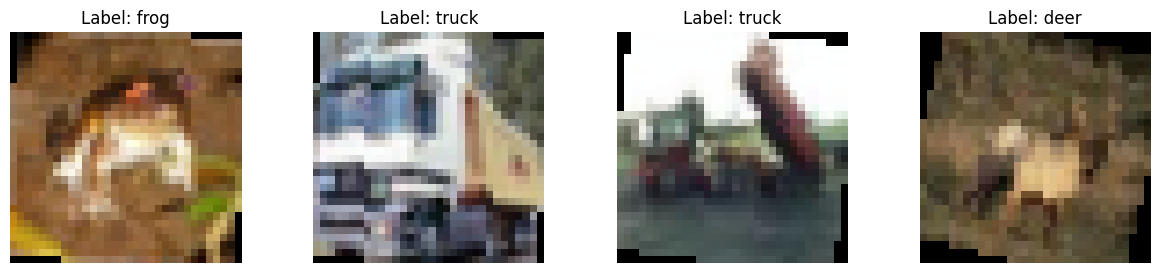

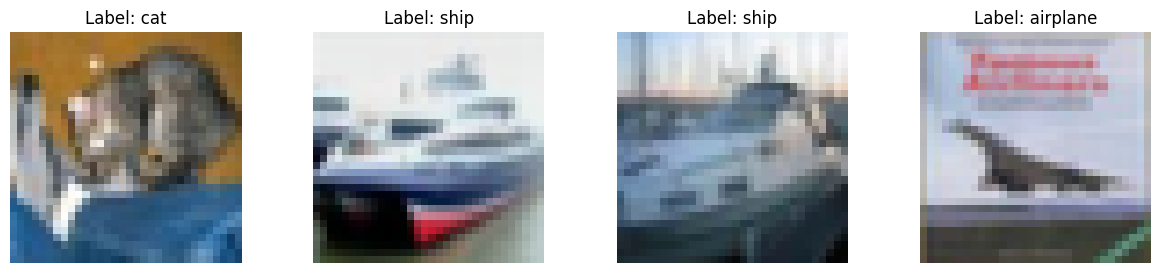

In [42]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [43]:
model_path = "./model/" + args.datasets + "/benchmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [44]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [45]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [46]:
# net = UPANets(args.filters, Num_class, args.blocks, img_size)
# net.load_state_dict(copy.deepcopy(benckmark_state_dict))

# criterion = torch.nn.CrossEntropyLoss()

# net.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# optimizer = optim.SGD(net.parameters(),
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# # 保存模型架构+参数+优化器状态（完整恢复训练）
# model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# # 加载 

# # checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# # 模型结构需提前定义（需与保存时一致）
# # model = YourModelClass()  
# # model.load_state_dict(checkpoint['model_state_dict']) 
 
# # # 恢复优化器和训练状态 
# # optimizer = torch.optim.Adam(model.parameters())  
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# # with open('data.json',  'r', encoding='utf-8') as f:
# #     loaded_dict = json.load(f) 


# # summary(net, (3, img_size, img_size))


In [47]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.2, 
#                 max_beta = 2.0, 
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [48]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.001, 
#                 max_beta = 2.0, 
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [49]:
# for i in range(5):
#     if metricsr_sin['bast_acc'] < 0.7234:
#         net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
#         net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
#         criterion = torch.nn.CrossEntropyLoss()

#         net_pugdr_cos.to(device)

#         if device == 'cuda' and torch.cuda.device_count() > 1:
#             model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#             cudnn.benchmark = True

#         base_optimizer = optim.SGD
#         optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                         base_optimizer,
#                         lr=args.lr,
#                         max_epochs= args.epochs,
#                         momentum=args.momentum,
#                         weight_decay=args.wd,
#                         min_beta = 0.0, 
#                         max_beta = 2.0, 
#                         method = 'cos',
#                         dampening=0,   # 必须设置为0才能完全固定 
#                         nesterov=False # 禁用Nesterov动量 
#                         )

#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
#         # Decay LR by a factor of 0.1 every 7 epochs
#         # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#         net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

#         model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
#         torch.save({
#             'model_state_dict': net_pugdr_cos.state_dict(), 
#             'optimizer_state_dict': optimizer.state_dict()
#         }, model_path) 

#         name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
#         with open(name,  'w', encoding='utf-8') as f:
#             json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [50]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.0, 
#                 max_beta = 3.0, 
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [51]:
# net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.2, 
#                 max_beta = 3.0,
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [52]:
# net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.8, 
#                 max_beta = 2.0,
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [53]:
# net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugd.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugd)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(net_pugd.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugd.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [54]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.3, 
#                 max_beta = 1, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [55]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 1, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [56]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.01, 
#                 max_beta = 0.5, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [57]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.05, 
#                 max_beta = 1.0, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [58]:
# net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_isin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_isin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 2,
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_isin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [59]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.01, 
#                 max_beta_r = 2, 
#                 method_r = 'isin',
#                 min_beta_s = 0, 
#                 max_beta_s = 1.5,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [60]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.0,
#                 max_beta_r = 2.0,
#                 method_r = 'sin',
#                 min_beta_s = 0.0, 
#                 max_beta_s = 2.0,
#                 method_s = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [61]:
# VGG-16 ResNet-18 DenseNet-121* growth rate in 16 UPANet-16 Overall Average

In [62]:
# ## finetune

# from transformers import ViTForImageClassification, DeiTForImageClassification 
 
# # 加载预训练模型 
# vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 



In [63]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
#     optimizer,  # 绑定的优化器对象 
#     mode='max',  # 监测指标模式 
#     factor=0.5,  # 学习率衰减系数 
#     patience=3   # 等待周期数 
# )
# for name, param in vit_model.named_parameters(): 
#     if 'encoder.layer.0'  in name:  # 冻结前N层 
#         param.requires_grad  = False 
# # 修改分类头以适应CIFAR-10的10类 
# vit_model.classifier  = torch.nn.Linear(vit_model.config.hidden_size,  10)
# deit_model.classifier  = torch.nn.Linear(deit_model.config.hidden_size,  10)

In [64]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [65]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 

In [66]:
# ft_epochs = 300
# os.environ.update({ 
#     "HF_ENDPOINT": "https://hf-mirror.com", 
#     "HF_HUB_OFFLINE": "0",  # 确保非离线模式 
#     "HF_HUB_DISABLE_TELEMETRY": "1",  # 禁用检测请求 
#     "HF_CDN_DOMAIN": "hf-mirror.com", 
#     "HF_S3_ENDPOINT": "hf-mirror.com", 
#     "TRANSFORMERS_OFFLINE": "0",       # transformers专用设置 
#     "HF_DATASETS_OFFLINE": "0"         # datasets专用设置 
# })

In [67]:
# import requests 
# endpoints = ["https://hf-mirror.com",  "https://huggingface.co"] 
# for url in endpoints:
#     try:
#         r = requests.get(f"{url}/api/models",  timeout=5)
#         print(f"{url} 响应状态: {r.status_code}") 
#     except Exception as e:
#         print(f"{url} 连接失败: {type(e).__name__}")

In [68]:
ft_epochs = 300
# 加载预训练ResNet18
resnet18 = models.resnet18(weights=("pretrained", models.ResNet18_Weights.IMAGENET1K_V1))

# 冻结所有卷积层
# for name, param in resnet18.named_parameters(): 
#     if 'fc' not in name:  # 排除最后的全连接层
#         param.requires_grad  = False

resnet18.fc  = torch.nn.Linear(resnet18.fc.in_features,  Num_class)

In [ ]:
resnet18_copy1 = copy.deepcopy(resnet18)
criterion = torch.nn.CrossEntropyLoss()

resnet18_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(resnet18_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(resnet18_copy1.parameters(),
                base_optimizer,
                lr=0.01,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_copy1, metrics0 = train_model(resnet18_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/resnet18_pugd" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': resnet18_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/resnet18_pugd_" + str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/299
7.791322708129883
Epoch 1/299
7.588793039321899
Epoch 2/299
7.86086106300354
Epoch 3/299
7.656046152114868
Epoch 4/299
7.701139211654663
Epoch 5/299
7.6561877727508545
Epoch 6/299
7.627509355545044
Epoch 7/299
7.6600117683410645
Epoch 8/299
7.603913068771362
Epoch 9/299
7.647732496261597
Epoch 10/299
7.548749923706055
Epoch 11/299
7.618535995483398
Epoch 12/299
7.694027900695801
Epoch 13/299
7.605334043502808
Epoch 14/299
7.52229905128479
Epoch 15/299
7.59897255897522
Epoch 16/299
7.799351930618286
Epoch 17/299
7.612516641616821
Epoch 18/299
7.60531759262085
Epoch 19/299
7.658989667892456
Epoch 20/299
7.687312364578247
Epoch 21/299
7.633037567138672
Epoch 22/299
7.77065634727478
Epoch 23/299
7.622539281845093
Epoch 24/299
7.588796377182007
Epoch 25/299
7.576785564422607
Epoch 26/299
7.660423040390015
Epoch 27/299
7.572794675827026
Epoch 28/299
7.606537580490112
Epoch 29/299
7.745173692703247
Epoch 30/299
7.568406820297241
Epoch 31/299
8.088048219680786
Epoch 32/299
8.339443

In [ ]:
resnet18_copy1 = copy.deepcopy(resnet18)
criterion = torch.nn.CrossEntropyLoss()

resnet18_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(resnet18_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(resnet18_copy1.parameters(),
                base_optimizer,
                lr=0.01,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.5, 
                max_beta = 1, 
                method = 'isin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_copy1, metrics0 = train_model(resnet18_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': resnet18_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" +  str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/299
8.614818096160889
Epoch 1/299
8.484698057174683
Epoch 2/299
8.480557203292847
Epoch 3/299
8.60815143585205
Epoch 4/299
8.467992544174194
Epoch 5/299
8.501445293426514
Epoch 6/299
8.441718339920044
Epoch 7/299
8.481943845748901
Epoch 8/299
8.574955224990845
Epoch 9/299
8.59570574760437
Epoch 10/299
8.650724172592163
Epoch 11/299
8.547104597091675
Epoch 12/299
8.509070873260498
Epoch 13/299
8.433101415634155
Epoch 14/299
8.485283374786377
Epoch 15/299
8.47225284576416
Epoch 16/299
8.572571992874146
Epoch 17/299
8.42900276184082
Epoch 18/299
8.509242057800293
Epoch 19/299
8.580318450927734
Epoch 20/299
8.459119081497192
Epoch 21/299
8.548299789428711
Epoch 22/299
8.572463750839233
Epoch 23/299
8.702510595321655
Epoch 24/299
8.485719680786133
Epoch 25/299
8.448039293289185
Epoch 26/299
8.460539817810059
Epoch 27/299
8.445878982543945
Epoch 28/299
8.458104610443115
Epoch 29/299
8.526161432266235
Epoch 30/299
8.653056621551514
Epoch 31/299
8.476912021636963
Epoch 32/299
8.3923728

In [71]:
# from transformers import ViTImageProcessor, ViTForImageClassification
ft_epochs = 200
# 加载预训练ViT-B/16
vit = timm.create_model('google/vit_base_patch16_224',  pretrained=True, 
                        img_size = 32, patch_size = 8, num_classes = Num_class)

# vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
#                                                 img_size = 32, patch_size = 8, num_classes = Num_class)
# 冻结除head外的所有层
# for name, param in vit.named_parameters(): 
#     if 'heads.head'  not in name:  # 仅保留分类头可训练
#         param.requires_grad  = False

# vit.heads.head  = torch.nn.Linear(vit.heads.head.in_features,  Num_class)



In [ ]:
vit_copy1 = copy.deepcopy(vit)
criterion = torch.nn.CrossEntropyLoss()

vit_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(vit_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(vit_copy1.parameters(),
                base_optimizer,
                lr=0.001,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

vit_copy1, metrics0 = train_model(vit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/vit_pugd" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': vit_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/vit_pugd_" + str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)

Epoch 0/199
87.27649283409119
Epoch 1/199
87.01743006706238
Epoch 2/199
86.75871515274048
Epoch 3/199
86.80527639389038
Epoch 4/199
86.87925100326538
Epoch 5/199
87.11076617240906
Epoch 6/199
87.28419828414917
Epoch 7/199
87.24719214439392
Epoch 8/199
87.49161767959595
Epoch 9/199
87.58965992927551
Epoch 10/199
87.84839344024658
Epoch 11/199
87.69825434684753
Epoch 12/199
87.65998148918152
Epoch 13/199
87.66978287696838
Epoch 14/199
87.75122427940369
Epoch 15/199
87.65101051330566
Epoch 16/199
87.6350781917572
Epoch 17/199
87.27856397628784
Epoch 18/199
87.18223071098328
Epoch 19/199
87.21493172645569
Epoch 20/199
87.33242893218994
Epoch 21/199
87.37593650817871
Epoch 22/199
87.49761199951172
Epoch 23/199
87.66464948654175
Epoch 24/199
87.74119424819946
Epoch 25/199
87.80505013465881
Epoch 26/199
87.68211770057678
Epoch 27/199
87.76371812820435
Epoch 28/199
87.77299094200134
Epoch 29/199
88.03620386123657
Epoch 30/199
87.74037075042725
Epoch 31/199
87.69756507873535
Epoch 32/199
87.835

In [ ]:
vit_copy1 = copy.deepcopy(vit)
criterion = torch.nn.CrossEntropyLoss()

vit_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(vit_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(vit_copy1.parameters(),
                base_optimizer,
                lr=0.001,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.1, 
                max_beta = 2, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

vit_copy1, metrics0 = train_model(vit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/vit_pugd_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': vit_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/vit_pugd_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199
87.43074703216553
Epoch 1/199
87.50903058052063
Epoch 2/199
87.60423803329468
Epoch 3/199
87.55445718765259
Epoch 4/199
87.74158883094788
Epoch 5/199
87.70942878723145
Epoch 6/199
87.8306143283844
Epoch 7/199
87.64871406555176
Epoch 8/199
87.71636486053467
Epoch 9/199
87.82065057754517
Epoch 10/199
87.91743326187134
Epoch 11/199
87.72715997695923
Epoch 12/199
87.8803722858429
Epoch 13/199
87.81188583374023
Epoch 14/199
87.8195013999939
Epoch 15/199
87.93416428565979
Epoch 16/199
87.93970823287964
Epoch 17/199
87.94647550582886
Epoch 18/199
87.90225553512573
Epoch 19/199
87.79440569877625
Epoch 20/199
87.80140924453735
Epoch 21/199
87.73399066925049
Epoch 22/199
87.70495939254761
Epoch 23/199
87.96953701972961
Epoch 24/199
87.89654684066772
Epoch 25/199
87.89340591430664
Epoch 26/199
87.87587666511536
Epoch 27/199
87.9213433265686
Epoch 28/199
87.7792444229126
Epoch 29/199
87.87321782112122
Epoch 30/199
87.28893280029297
Epoch 31/199
87.11319947242737
Epoch 32/199
87.1862983

In [74]:
# # 加载预训练DeiT-B/16
deit = timm.create_model('deit_base_patch16_224', pretrained=True, 
                        img_size = 32, patch_size = 8, num_classes = Num_class)
ft_epochs = 300
# # 冻结所有层除了分类token和head
# for name, param in deit.named_parameters(): 
#     if not name.startswith(('cls_token',  'pos_embed', 'head')):
#         param.requires_grad  = False

# # 修改分类头（20类任务示例）
# deit.head  = torch.nn.Linear(deit.head.in_features,  Num_class)


In [ ]:
deit_copy1 = copy.deepcopy(deit)
criterion = torch.nn.CrossEntropyLoss()

deit_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(deit_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(deit_copy1.parameters(),
                base_optimizer,
                lr=0.0005,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

deit_copy1, metrics0 = train_model(deit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/deit_pugd" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': deit_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/deit_pugd_" + str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/299
87.9381730556488
Epoch 1/299
87.79314637184143
Epoch 2/299
87.83815598487854
Epoch 3/299
87.89583826065063
Epoch 4/299
87.96307325363159
Epoch 5/299
87.88075923919678
Epoch 6/299
87.871258020401
Epoch 7/299
87.90223145484924
Epoch 8/299
87.81615900993347
Epoch 9/299
87.87571978569031
Epoch 10/299
87.95237350463867
Epoch 11/299
87.80326414108276
Epoch 12/299
87.85398173332214
Epoch 13/299
87.85771036148071
Epoch 14/299
87.8468725681305
Epoch 15/299
87.79708290100098
Epoch 16/299
87.80381846427917
Epoch 17/299
87.93544459342957
Epoch 18/299
87.77240204811096
Epoch 19/299
87.93308997154236
Epoch 20/299
87.90068578720093
Epoch 21/299
87.86560845375061
Epoch 22/299
87.85792851448059
Epoch 23/299
87.97219848632812
Epoch 24/299
87.8548629283905
Epoch 25/299
87.82375597953796
Epoch 26/299
87.9475109577179
Epoch 27/299
87.99560785293579
Epoch 28/299
87.92789936065674
Epoch 29/299
87.90910935401917
Epoch 30/299
88.076895236969
Epoch 31/299
87.99578213691711
Epoch 32/299
87.9862229824